In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json, os

In [2]:
models = [
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_m3d_M3dSegmentation/", "M3D-NCA"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_OctreeNCASegmentation/", "OctreeNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostatefAbl_none_10_1.0_16_OctreeNCASegmentation/", "OctreeNCA"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostateNN_lossweight_OctreeNCASegmentation/", "OctreeNCANN"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostateAbl_none_10_1.0_20_OctreeNCASegmentation/", "OctreeNCAnew"),

    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_efficientnet-b0_0_MinUNetSegmentation/", "UNet2D Efficientnet"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_mobilenet_v2_0_MinUNetSegmentation/", "UNet2D Mobilenetv2"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_resnet18_0_MinUNetSegmentation/", "UNet2D Resnet18"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_UNet_vgg11_0_MinUNetSegmentation/", "UNet2D VGG11"),

    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet_UNetSegmentation/", "UNet"),#UNet3D
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_unetXXXS_UNetSegmentation/", "UNet3D XXXS"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet4XS_UNetSegmentation/", "UNet3D 4XS"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_munet3d_UNet_resnet18_0_minUNet3DSegmentation/", "Resnet18"),#UNet3D Resnet18
    ("/local/scratch/clmn1/octree_study_new/Experiments/prostate_munet3d_UNet_densenet121_0_minUNet3DSegmentation/", "Densenet"),#UNet3D Resnet18
]

In [3]:
annnotation_list = []
annotation_dict = {}
all_files = []
for i, (model, model_name) in enumerate(models):
    score = pd.read_csv(f"{model}eval/standard.csv", sep='\t').loc[:, "DiceScore/0"] * 100

    score_std = score.std()
    score = score.mean()

    mem_allocation = json.load(open(f"{model}/mem_allocation.json"))["byte"]
    num_params = json.load(open(f"{model}/num_params.json"))["num_params"]

    eval_file = {}

    eval_file["model"] = model
    eval_file["mem_allocation"] = mem_allocation
    eval_file["num_params"] = num_params
    eval_file["score"] = score
    eval_file["score_std"] = score_std
    df = pd.DataFrame(index=[i], data=eval_file)
    all_files.append(df)
    annnotation_list.append((num_params, score, model_name))
    annotation_dict[model_name] = (num_params, score)

all_files = pd.concat(all_files)

In [4]:
def get_nnUNet_results(path: str, trainer: str) -> dict:
    FOLD = 0
    TRAIN_TASK = "Task506_Prostate_MEDSeg_split"
    EVAL_TASK = "Task508_Prostate_MEDSeg_split" 
    #both are the same dataset. However 506 is not properly preprocessed, so it cannot be used for evaluation
    # Later I preprocessed 508 correctly, which can also be used for evaluation. Future work should use 508 for training and evaluation

    eval_path = os.path.join(path,"evaluation", "nnUNet_ext", "3d_fullres",
                             TRAIN_TASK, TRAIN_TASK, f"{trainer}__nnUNetPlansv2.1", 
                             f"Generic_UNet/SEQ/head_None/fold_{FOLD}",EVAL_TASK,
                             "val_metrics_all.csv")
    results_path = os.path.join(path, "results", "nnUNet_ext", "3d_fullres",
                             TRAIN_TASK, TRAIN_TASK, f"{trainer}__nnUNetPlansv2.1", 
                             f"Generic_UNet/SEQ/fold_{FOLD}")
    results = pd.read_csv(eval_path, sep='\t')
    results = results[results["split"] == "test"]
    results = results[results["seg_mask"] == "mask_1"]
    results = results[results["metric"] == "Dice"]

    model_name = {
        "nnUNetTrainerNCA": "nnNCA",
        "nnUNetTrainerSequential": "nnUNet",
    }
    ret = {
        "model": model_name[trainer],
        "mem_allocation": json.load(open(os.path.join(results_path, "mem_allocation.json")))["byte"],
        "num_params": json.load(open(os.path.join(results_path, "num_params.json")))["num_params"],
        "score": results["value"].mean() * 100,
        "score_std": (results["value"] * 100).std()
    }
    return ret

In [5]:
nnOctreeNCA = get_nnUNet_results("/local/scratch/clmn1/nnunet_nca", "nnUNetTrainerNCA")
nnUNet = get_nnUNet_results("/local/scratch/clmn1/nnunet_nca", "nnUNetTrainerSequential")
data = [nnUNet]
df = pd.DataFrame(data=data)
all_files = pd.concat([all_files, df])
for model_d in data:
    annnotation_list.append((model_d["num_params"], model_d["score"], model_d["model"]))
    annotation_dict[model_d["model"]] = (model_d["num_params"], model_d["score"])

In [6]:
from IPython.display import display, HTML
display(HTML(all_files.to_html()))

,model,mem_allocation,num_params,score,score_std
0,/local/scratch/clmn1/octree_study_new/Experiments/prostate_m3d_M3dSegmentation/,15401065984,12480,80.517897,2.590593
1,/local/scratch/clmn1/octree_study_new/Experiments/prostatefAbl_none_10_1.0_16_OctreeNCASegmentation/,2341291520,17600,82.507013,5.463937
2,/local/scratch/clmn1/octree_study_new/Experiments/prostate_unet_UNetSegmentation/,8363604480,19071297,84.063721,6.340254
3,/local/scratch/clmn1/octree_study_new/Experiments/prostate_munet3d_UNet_resnet18_0_minUNet3DSegmentation/,4614624768,42611121,85.619158,3.735631
4,/local/scratch/clmn1/octree_study_new/Experiments/prostate_munet3d_UNet_densenet121_0_minUNet3DSegmentation/,6661970432,31199985,84.759669,4.039889
0,nnUNet,7889388032,44797408,88.180718,3.245364


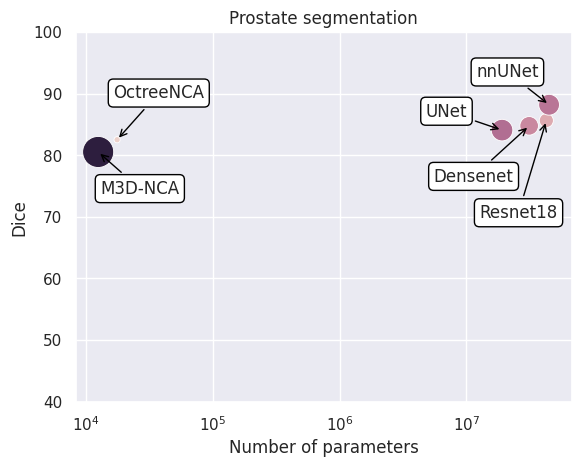

In [7]:
sns.set_theme()
ax = sns.scatterplot(data=all_files, x="num_params", y="score", hue="mem_allocation", size="mem_allocation",legend=False, sizes=(20, 500))
for x,y,txt in annnotation_list:
    pass
    #ax.annotate(txt, (x,y), textcoords="offset points", xytext=(0,10), ha='center')


def my_annotate(name, xytext):
    ax.annotate(name, annotation_dict[name], textcoords="offset points", xytext=xytext, ha='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        arrowprops=dict(arrowstyle="->", color='black'))

my_annotate("M3D-NCA", (30, -30))
my_annotate("OctreeNCA", (30, 30))
my_annotate("Resnet18", (-20, -70))
my_annotate("nnUNet", (-30, 20))
my_annotate("UNet", (-40, 10))
my_annotate("Densenet", (-40, -40))

plt.xscale("log")
plt.xlabel("Number of parameters")
plt.ylabel("Dice")
plt.title("Prostate segmentation")
plt.ylim(40, 100)
plt.savefig("figures/prostate_segmentation.pdf", bbox_inches='tight')